In [1]:
# import system libraries
import logging
import sys, copy
# import scientific libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import h5py
import pandas as pd
# import data analysis libraries
from ldc.waveform.lisabeta import FastBHB
import lisabeta.lisa.lisa as lisa
from lisabeta.lisa.lisa import EvaluateTDIFreqseries
import lisabeta.tools.pyspline as pyspline
import lisabeta.lisa.lisatools as lisatools
import lisabeta.tools.pytools as pytools
from ldc.common import tools
from ldc.lisa.noise import AnalyticNoise, get_noise_model
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import lisaconstants
# import sampler libraries
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import uniform_dist, ProbDistContainer

mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
pMBHB_ldc = {
            'EclipticLatitude': -0.30300442294174235,
            'EclipticLongitude': 1.2925183861048521,
            'PolarAngleOfSpin1': 1.2031361791056812,
            'PolarAngleOfSpin2': 2.097303543065685,
            'Spin1': 0.747377,
            'Spin2': 0.8388,
            'Mass1': 1323277.47932,
            'Mass2': 612485.5060299999,
            'CoalescenceTime': 11526944.921879262,
            'PhaseAtCoalescence': 1.2201968860015653,
            'InitialPolarAngleL': 2.6919824500032945,
            'InitialAzimuthalAngleL': 1.808398497592109,
            'Redshift': 1.73941,
            'Distance': 13449.011,
            'ObservationDuration': 31558149.763545603,
            'Cadence': 3.0}

In [3]:
dt = 5
tmax = 3.155815e+05 # in [sec]
df = 1/tmax

In [4]:
FBH = FastBHB("MBHB", T=tmax, delta_t=dt, approx="IMRPhenomD")

pMBHB = FBH.rename_as_lisabeta(pMBHB_ldc)

print(pMBHB.keys())

dict_keys(['beta', 'lambda', 'chi1', 'chi2', 'm1', 'm2', 'Deltat', 'phi', 'dist', 'psi', 'inc'])


In [5]:
waveform_params_smbh = {
    "minf": 1e-5,
    "maxf": 1,
    "t0": 0.0,
    "timetomerger_max": 1.0,
    "tmax": 1.0,
    "TDI": "TDI2AET",
    "approximant": "IMRPhenomD",
    "TDIrescaled": False,
}

In [6]:
tdisignal = lisa.GenerateLISATDISignal_SMBH(pMBHB, **waveform_params_smbh)
tdi = tdisignal['tdi']
mbh_lb = tdi[(2,2)]

In [7]:
freq = mbh_lb['freq']
freq = freq[freq>0]

In [8]:
A_full = np.conjugate((mbh_lb['amp_real_chan1'] + 1.j*mbh_lb['amp_imag_chan1'])*np.exp(1j* mbh_lb['phase']))
E_full = np.conjugate((mbh_lb['amp_real_chan2'] + 1.j*mbh_lb['amp_imag_chan2'])*np.exp(1j* mbh_lb['phase']))

In [9]:
Nmodel = AnalyticNoise(freq, model="SciRDv1") # or whatever version you prefer. In the previous notebook we used "sangria"
Npsd = Nmodel.psd(option='A', tdi2=True)

In [10]:
fstar = 0.0190854 #c/L/(2*np.pi)
psd_sqrt = 2e-10*(np.sin(2*freq/fstar)**2 + 1e-12)/2.5e9 #2.5e9 is armlength
#10mm eyeball -> 8e-10
#2mm eyeball -> 2e-10
#1mm eyeball -> 6e-11

In [11]:
#Add noise to noise
def randc(r):
    return r/np.sqrt(2)*(np.random.randn(*r.shape) + 1j*np.random.randn(*r.shape))

noise_fft = randc(psd_sqrt)

In [12]:
#add noisy noise to signal
Afull = A_full+ noise_fft/np.sqrt(df*4)
Efull = E_full+ noise_fft/np.sqrt(df*4)

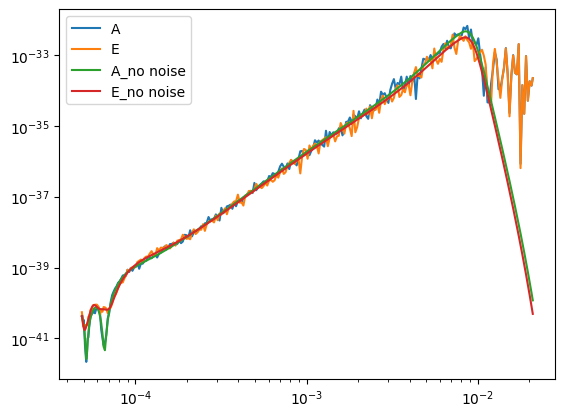

In [13]:
plt.loglog(freq, np.abs(Afull)**2, label = 'A')
plt.loglog(freq, np.abs(Efull)**2, label = 'E')
plt.loglog(freq, np.abs(A_full)**2, label = 'A_no noise')
plt.loglog(freq, np.abs(E_full)**2, label = 'E_no noise')
plt.legend()
plt.show()

In [14]:
#solving for chirpmass and ratio
m1 = pMBHB['m1']
m2 = pMBHB['m2']
q = m1/m2
Mc = (m1+m2)*(q/(1+q)**2)**0.6

src0 = pMBHB.copy()
src0.pop("m1"); src0.pop("m2")
src0["Mchirp"] = Mc
src0["q"] = q
src0['psi'] += np.pi
src0['phi'] -= np.pi

keys = src0.keys()

#create the array to be altered in likelihood
src = copy.deepcopy(src0)

In [15]:
def likelihood(params):
    Mc, q, dist = params[:]
    src["Mchirp"] = Mc
    src["q"] = q
    src["dist"] = dist

    tdisignal = lisa.GenerateLISATDISignal_SMBH(src,
                                                gridfreq=freq,
                                                **waveform_params_smbh)
    mbh_lb = tdisignal['tdi'][(2,2)]

    A_trial = (np.conjugate((mbh_lb['amp_real_chan1'] + 1.j*mbh_lb['amp_imag_chan1'])*np.exp(1j* mbh_lb['phase'])))
    E_trial = (np.conjugate((mbh_lb['amp_real_chan2'] + 1.j*mbh_lb['amp_imag_chan2'])*np.exp(1j* mbh_lb['phase'])))

    SN_m = 4.0*df*np.sum(np.real(Afull*np.conjugate(A_trial))/Npsd) + 4.0*df*np.sum(np.real(Efull*np.conjugate(E_trial))/Npsd)

    XX = 4*df*np.sum(np.abs(A_trial)**2/Npsd) + 4*df*np.sum(np.abs(E_trial)**2/Npsd)

    loglik = SN_m - 0.5*XX
    return loglik

In [16]:
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e4, 1e7), #mc
    1: uniform_dist(1, 30), #q
    2: uniform_dist(2000.0, 2000000.0) #dist
})}

In [17]:
ntemps = 5
nwalkers = 22
nsamples = 400
ndims = {"mbh": 3}

In [18]:

theta0 = np.array([[np.hstack(
          (np.random.randn(3) * 1e-8) + np.array([src0["Mchirp"], src0["q"], src0["dist"]]))
          for i in range(nwalkers)]
          for _ in range(ntemps)])

start_state = State({"mbh": theta0})

In [19]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood,
    priors,
    args=(),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
)

In [20]:
sampler.run_mcmc(start_state, nsamples, progress=True)

100%|██████████| 400/400 [00:25<00:00, 15.63it/s]


In [ ]:
burn = 3000
c = ChainConsumer()
pnames = ["Mchirp","q","dist"]

samples_2ch = sampler.get_chain()["mbh"][:, 0].reshape(-1, 3)

dfs_2chnls = pd.DataFrame(samples_2ch[burn:, :], columns = pnames)

c.add_chain(Chain(samples=dfs_2chnls, name="2mm eyeball"))

In [22]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood,
    priors,
    args=(),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
)

In [23]:

psd_sqrt = 8e-10*(np.sin(2*freq/fstar)**2 + 1e-12)/2.5e9 #2.5e9 is armlength
noise_fft = randc(psd_sqrt)

Afull = A_full+ noise_fft/np.sqrt(df*4)
Efull = E_full+ noise_fft/np.sqrt(df*4)
#10mm eyeball -> 8e-10
#2mm eyeball -> 2e-10
#1mm eyeball -> 6e-11

In [24]:
sampler.run_mcmc(start_state, nsamples, progress=True)

100%|██████████| 400/400 [00:25<00:00, 15.79it/s]


In [25]:
pnames = ["Mchirp","q","dist"]

ch = sampler.get_chain()["mbh"][:, 0].reshape(-1, 3)

chnls = pd.DataFrame(ch[burn:, :], columns = pnames)

c.add_chain(Chain(samples=chnls, name="10mm eyeball"))

In [26]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood,
    priors,
    args=(),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
)

In [27]:
psd_sqrt = 6e-11*(np.sin(2*freq/fstar)**2 + 1e-12)/2.5e9 #2.5e9 is armlength
noise_fft = randc(psd_sqrt)

Afull = A_full+ noise_fft/np.sqrt(df*4)
Efull = E_full+ noise_fft/np.sqrt(df*4)
#10mm eyeball -> 8e-10
#2mm eyeball -> 2e-10
#1mm eyeball -> 6e-11

In [28]:
sampler.run_mcmc(start_state, nsamples, progress=True)

100%|██████████| 400/400 [00:26<00:00, 15.34it/s]


In [29]:
pnames = ["Mchirp","q","dist"]

samples = sampler.get_chain()["mbh"][:, 0].reshape(-1, 3)

dfs = pd.DataFrame(samples[burn:, :], columns = pnames)

c.add_chain(Chain(samples=dfs, name="1mm eyeball"))

In [30]:
#set truth values and labels for corner plots and Chainconsumer

keys = src0.keys()
labels = list(keys)

inj=np.array([src0["Mchirp"], src0["q"], src0["dist"]])

truths = inj.flatten()
labels_final = labels
#c.add_truth(Truth(location={k:v for (k,v) in zip(labels_final,truths)}))

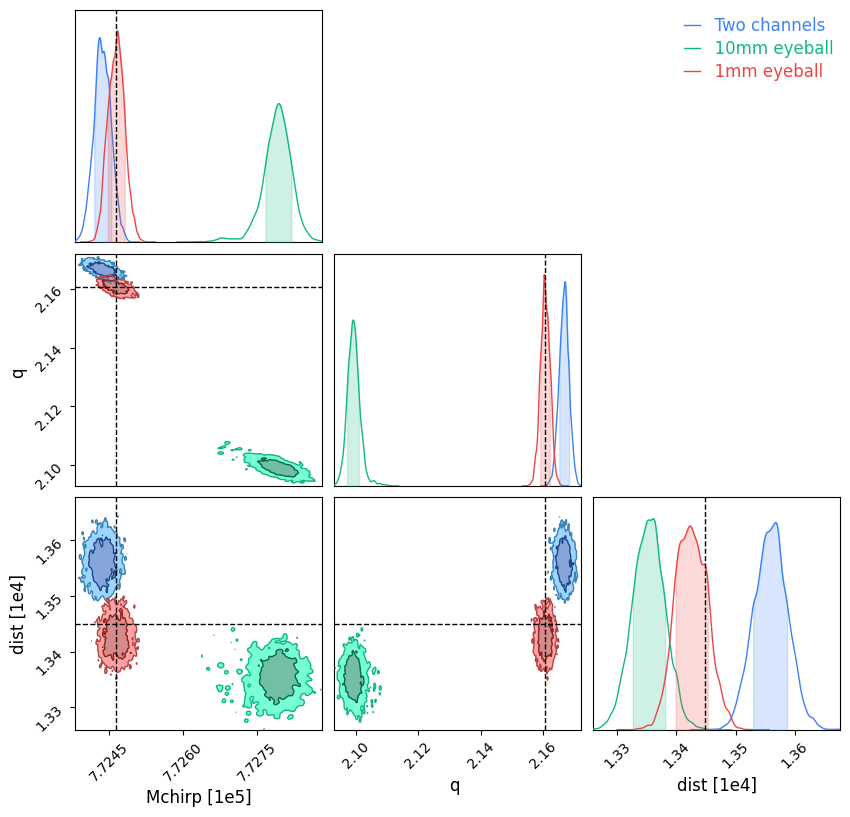

In [31]:

injection_params_sub = np.array([src0["Mchirp"], src0["q"], src0["dist"]])
c.add_truth(Truth(location={pnames[0]: injection_params_sub[0],
                            pnames[1]: injection_params_sub[1],
                            pnames[2]: injection_params_sub[2]}))

c.plotter.plot()
plt.show()

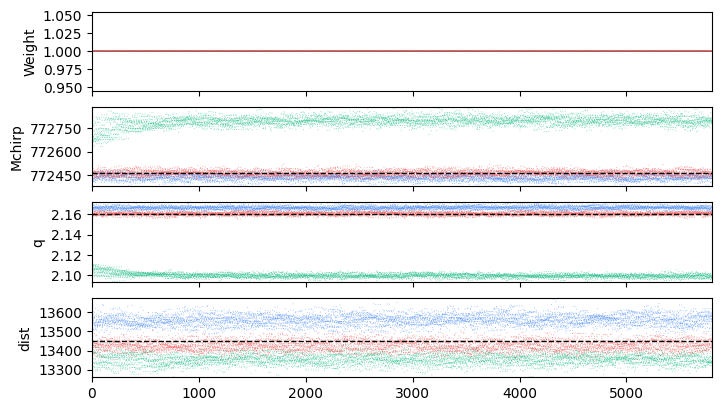

In [32]:
fig = c.plotter.plot_walks()
plt.show()